<a href="https://colab.research.google.com/github/Francky46/AttritionPrediction/blob/main/AttritionPrediction2.0..ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1>Attrition Prediction</h1></center>

# 1) Rédacteurs

- Francky MARTINI
- Yoann CJ
- Theotime COLINET

# 2) Politique d'éthique sur l'utilisation de l'IA pour la prédiction de l'attrition des employés
## 1.1) Introduction
L’intelligence artificielle (IA) est un outil puissant pouvant fournir des analyses précieuses dans divers domaines, notamment dans la prédiction de l’attrition des employés. Toutefois, son utilisation doit être encadrée par des principes éthiques clairs afin d’éviter tout usage abusif ou discriminatoire. Cette politique vise à définir les responsabilités des utilisateurs et à établir un cadre éthique pour une utilisation responsable de l’IA.

## 1.2) Responsabilité des utilisateurs
L’IA ne possède ni intention ni discernement moral ; elle se limite à exécuter des algorithmes basés sur les données qui lui sont fournies. Par conséquent, la responsabilité de son usage incombe exclusivement aux utilisateurs. Il appartient aux professionnels de veiller à ce que l’IA soit exploitée de manière éthique et conforme aux bonnes pratiques du domaine.

## 1.3) Usage strictement dédié à la prédiction de l'attrition
L’IA doit être utilisée uniquement pour son objectif initial : anticiper le départ potentiel des employés afin d’aider l’entreprise à prendre des décisions stratégiques éclairées. Toute utilisation détournée, notamment à des fins discriminatoires ou punitives, est strictement interdite et contraire aux principes d’éthique et de respect.

## 1.4) Interdiction de l'utilisation de variables sensibles
L’inclusion de variables sensibles telles que le sexe, l’âge, l’origine ethnique ou la situation matrimoniale peut entraîner des décisions biaisées et discriminatoires. Pour prévenir tout risque de discrimination, ces variables ne doivent en aucun cas influencer les analyses prédictives. Les utilisateurs doivent être formés et sensibilisés aux conséquences d’un usage inapproprié des données.

## 1.5) Transparence, responsabilité et vigilance
Les décisions prises sur la base des analyses de l’IA doivent être transparentes et compréhensibles. Il est essentiel que les professionnels puissent justifier les résultats obtenus et éviter toute prise de décision arbitraire ou automatisée. Une vérification humaine est nécessaire pour garantir que l’IA soit utilisée de manière juste et équitable.

## 1.6) Conformité au Règlement Général sur la Protection des Données (RGPD)
L’utilisation de l’IA pour la prédiction de l’attrition des employés doit être conforme au Règlement Général sur la Protection des Données (RGPD). Cela implique les obligations suivantes :
- Licéité, loyauté et transparence : La collecte et le traitement des données doivent être effectués de manière légitime, avec une information claire et accessible aux employés concernés.
- Finalité déterminée et limitée : Les données ne peuvent être utilisées que dans le cadre strict de la prédiction de l’attrition, et non à d’autres fins non autorisées.
- Minimisation des données : Seules les données strictement nécessaires doivent être collectées et traitées.
- Sécurité et confidentialité : Des mesures techniques et organisationnelles doivent être mises en place pour protéger les données contre tout accès non autorisé, perte ou fuite.
- Droits des employés : Les employés doivent être informés de l’utilisation de leurs données et pouvoir exercer leurs droits (accès, rectification, suppression, opposition, portabilité).
- Base légale du traitement : Toute utilisation de l’IA pour l’analyse des employés doit être justifiée par une base légale valide, comme l’intérêt légitime de l’entreprise ou le consentement explicite des employés.

Le non-respect de ces principes peut entraîner des sanctions conformément au RGPD et aux lois nationales en matière de protection des données.

## 1.7) Sensibilisation et formation des utilisateurs
Une formation continue des utilisateurs est indispensable afin qu’ils comprennent les implications éthiques et les limites de l’IA. Cette formation doit inclure :
- Les principes d’équité et de non-discrimination
- L’importance de la transparence et de l’explicabilité
- Les risques liés aux biais algorithmiques
- Les obligations en matière de protection des données personnelles (RGPD)
- Les bonnes pratiques pour une utilisation responsable de l’IA

## 1.8) Sanctions en cas d'abus
Toute utilisation abusive ou contraire à l’éthique sera fermement condamnée. Des mesures disciplinaires pourront être prises à l’encontre des utilisateurs qui exploiteraient l’IA de manière discriminatoire ou manipuleraient les résultats à des fins non conformes aux valeurs de l’entreprise ou ne respecteraient pas les exigences du RGPD..

## 1.9) Engagement pour une IA éthique et responsable
Nous prônons une approche où l’IA est un outil d’aide à la décision, et non un levier pour renforcer des pratiques discriminatoires. Transparence, responsabilité individuelle et vigilance sont essentielles pour garantir que cette technologie soit mise au service de décisions justes, équitables et éclairées.

Cette politique doit être régulièrement réévaluée afin de s’adapter aux évolutions technologiques et réglementaires en matière d’intelligence artificielle et d’éthique professionnelle.

# 2) Importation des librairies

In [ ]:
from cProfile import label

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Pour la séparation des données en train/test
from sklearn.model_selection import train_test_split

# Pour la création et l'évaluation de modèles
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, StackingClassifier


# Pour l'optimisation des hyperparamètres
from sklearn.model_selection import GridSearchCV

# 3) Chargement des données

In [ ]:
# Lis les différents fichiers CSV
folder = "src/"
df_general = pd.read_csv(folder + "general_data.csv")
df_emp_survey = pd.read_csv(folder + "employee_survey_data.csv")
df_mgr_survey = pd.read_csv(folder + "manager_survey_data.csv")
df_in_time = pd.read_csv(folder + "in_time.csv")
df_out_time = pd.read_csv(folder + "out_time.csv")

# 4) Exploration des données
## 4.1) Aperçu des données

In [ ]:
print("=== General Data ===")
print(df_general.head(), "\n")
print(df_general.info(), "\n")

print("=== Employee Survey Data ===")
print(df_emp_survey.head(), "\n")
print(df_emp_survey.info(), "\n")

print("=== Manager Survey Data ===")
print(df_mgr_survey.head(), "\n")
print(df_mgr_survey.info(), "\n")

print("=== In Time Data ===")
print(df_in_time.head(), "\n")
print(df_in_time.info(), "\n")

print("=== Out Time Data ===")
print(df_out_time.head(), "\n")
print(df_out_time.info(), "\n")

=== General Data ===
   Age Attrition     BusinessTravel              Department  DistanceFromHome  \
0   51        No      Travel_Rarely                   Sales                 6   
1   31       Yes  Travel_Frequently  Research & Development                10   
2   32        No  Travel_Frequently  Research & Development                17   
3   38        No         Non-Travel  Research & Development                 2   
4   32        No      Travel_Rarely  Research & Development                10   

   Education EducationField  EmployeeCount  EmployeeID  Gender  ...  \
0          2  Life Sciences              1           1  Female  ...   
1          1  Life Sciences              1           2  Female  ...   
2          4          Other              1           3    Male  ...   
3          5  Life Sciences              1           4    Male  ...   
4          1        Medical              1           5    Male  ...   

   NumCompaniesWorked Over18 PercentSalaryHike  StandardHours  \


## 4.2) Statistiques descriptives

In [ ]:
print("=== Statistiques descriptives (General Data) ===")
print(df_general.describe(), "\n")
print("=== Statistiques descriptives (Employee Survey Data) ===")
print(df_emp_survey.describe(), "\n")
print("=== Statistiques descriptives (Manager Survey Data) ===")
print(df_mgr_survey.describe(), "\n")
print("=== Statistiques descriptives (In Time Data) ===")
print(df_in_time.describe(), "\n")
print("=== Statistiques descriptives (Out Time Data) ===")
print(df_out_time.describe(), "\n")


=== Statistiques descriptives (General Data) ===
               Age  DistanceFromHome    Education  EmployeeCount   EmployeeID  \
count  4410.000000       4410.000000  4410.000000         4410.0  4410.000000   
mean     36.923810          9.192517     2.912925            1.0  2205.500000   
std       9.133301          8.105026     1.023933            0.0  1273.201673   
min      18.000000          1.000000     1.000000            1.0     1.000000   
25%      30.000000          2.000000     2.000000            1.0  1103.250000   
50%      36.000000          7.000000     3.000000            1.0  2205.500000   
75%      43.000000         14.000000     4.000000            1.0  3307.750000   
max      60.000000         29.000000     5.000000            1.0  4410.000000   

          JobLevel  MonthlyIncome  NumCompaniesWorked  PercentSalaryHike  \
count  4410.000000    4410.000000         4391.000000        4410.000000   
mean      2.063946   65029.312925            2.694830          15.209

## 4.3) Affichages des premières lignes

In [ ]:
for df in [df_general, df_emp_survey, df_mgr_survey, df_in_time, df_out_time]:
    print(df.head())

   Age Attrition     BusinessTravel              Department  DistanceFromHome  \
0   51        No      Travel_Rarely                   Sales                 6   
1   31       Yes  Travel_Frequently  Research & Development                10   
2   32        No  Travel_Frequently  Research & Development                17   
3   38        No         Non-Travel  Research & Development                 2   
4   32        No      Travel_Rarely  Research & Development                10   

   Education EducationField  EmployeeCount  EmployeeID  Gender  ...  \
0          2  Life Sciences              1           1  Female  ...   
1          1  Life Sciences              1           2  Female  ...   
2          4          Other              1           3    Male  ...   
3          5  Life Sciences              1           4    Male  ...   
4          1        Medical              1           5    Male  ...   

   NumCompaniesWorked Over18 PercentSalaryHike  StandardHours  \
0                 1.0

## 4.4) Analyse de la distribution des données

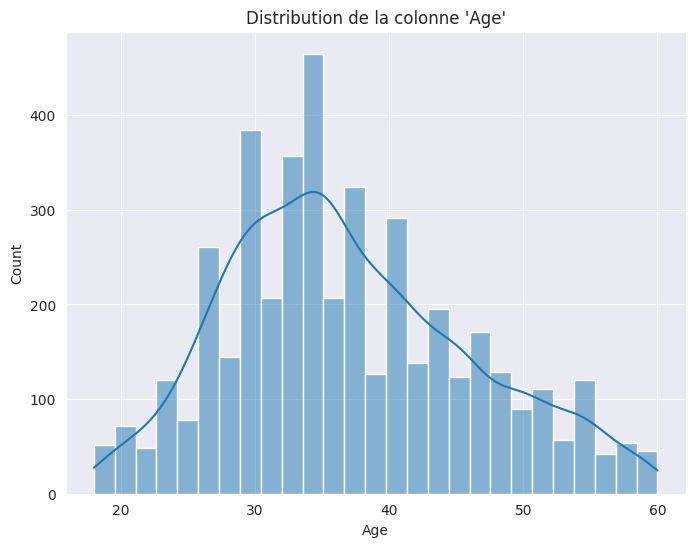

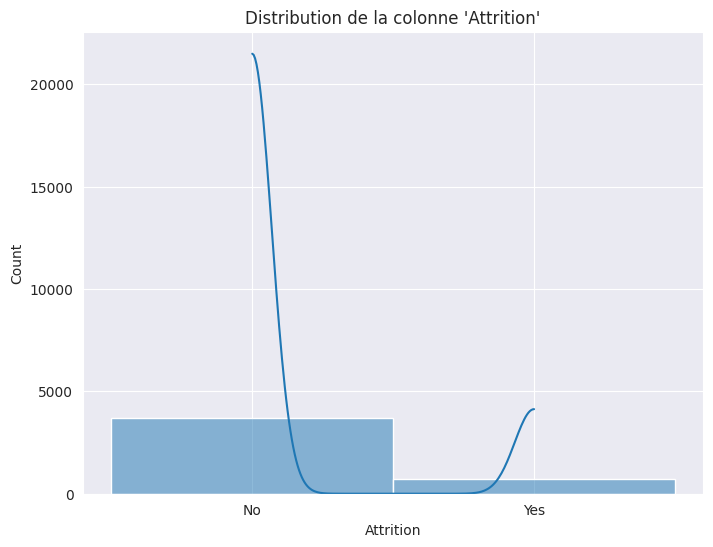

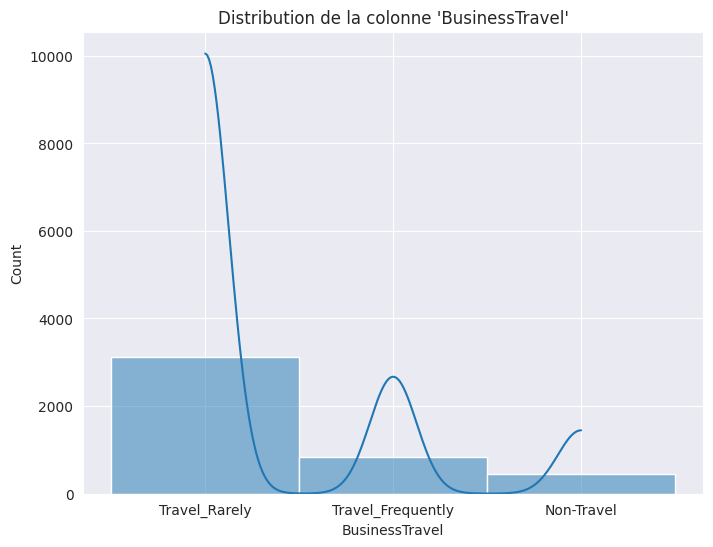

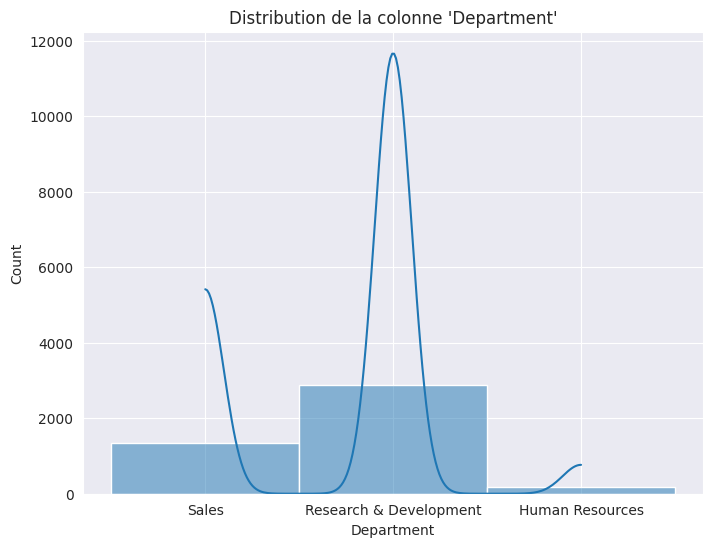

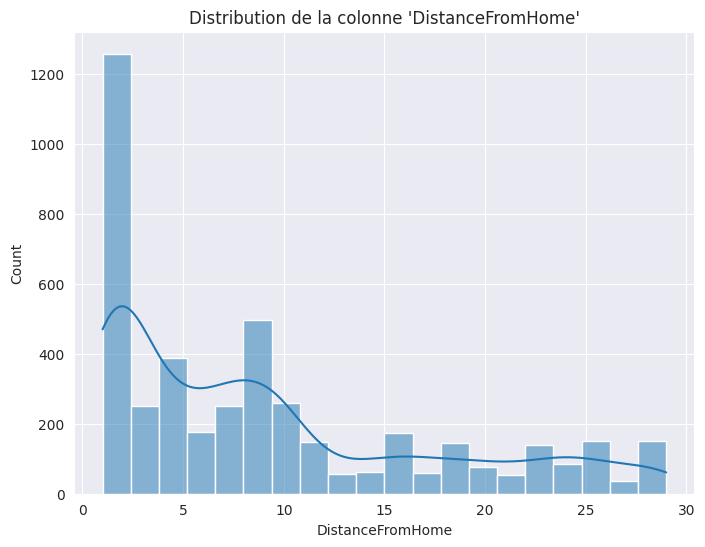

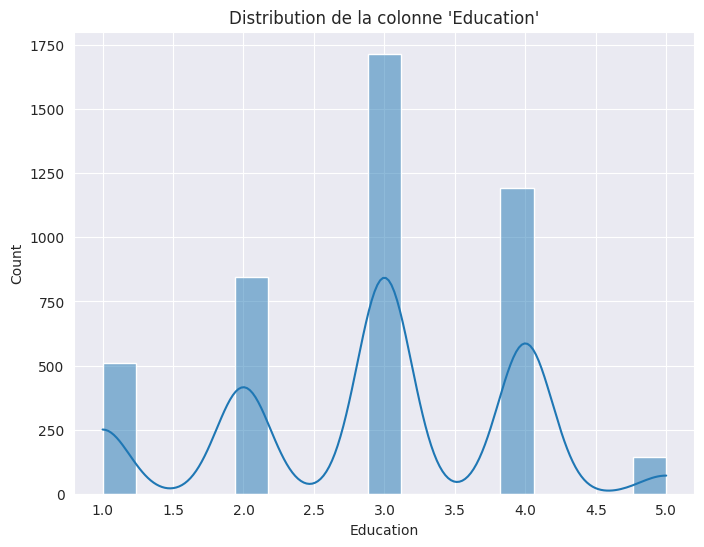

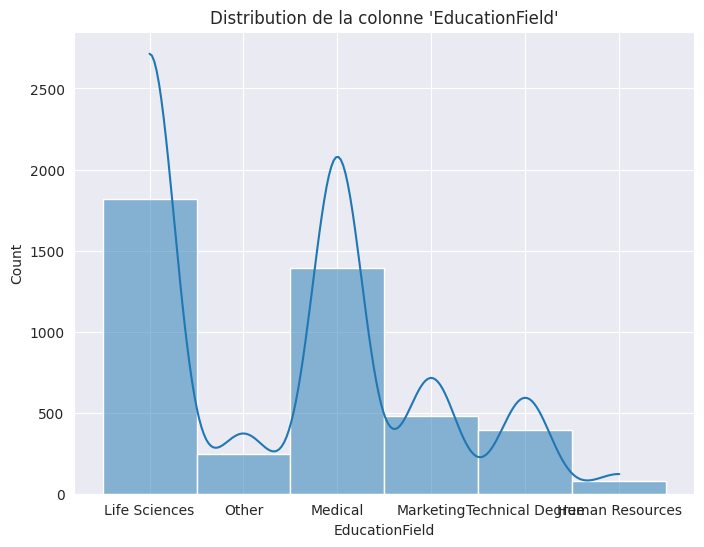

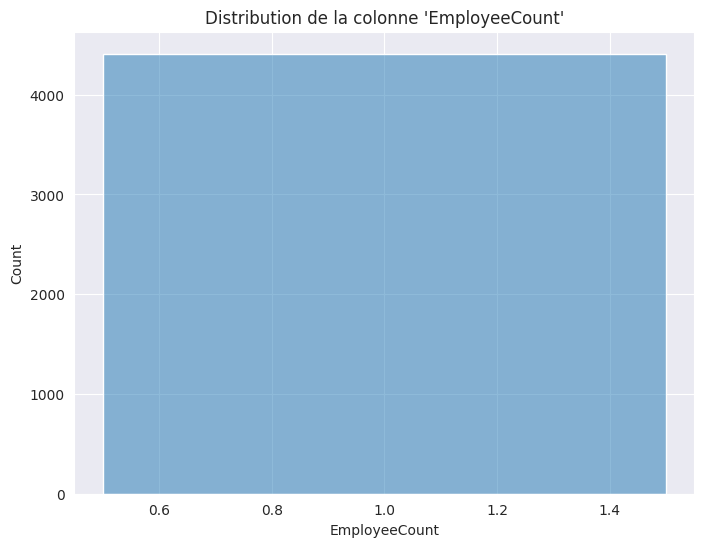

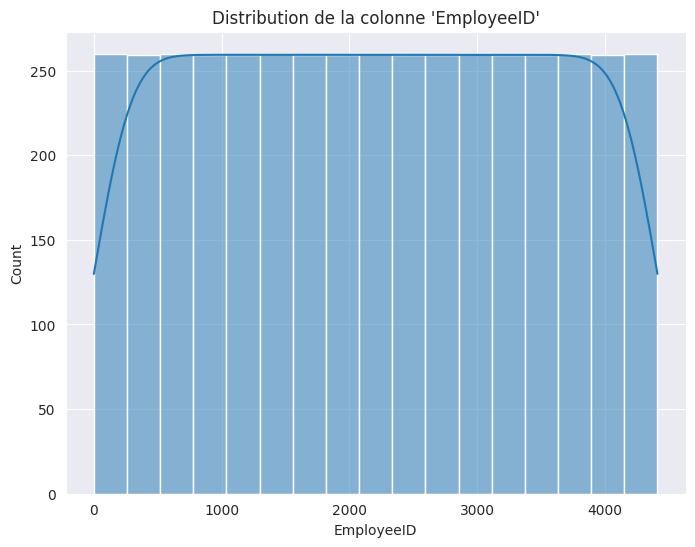

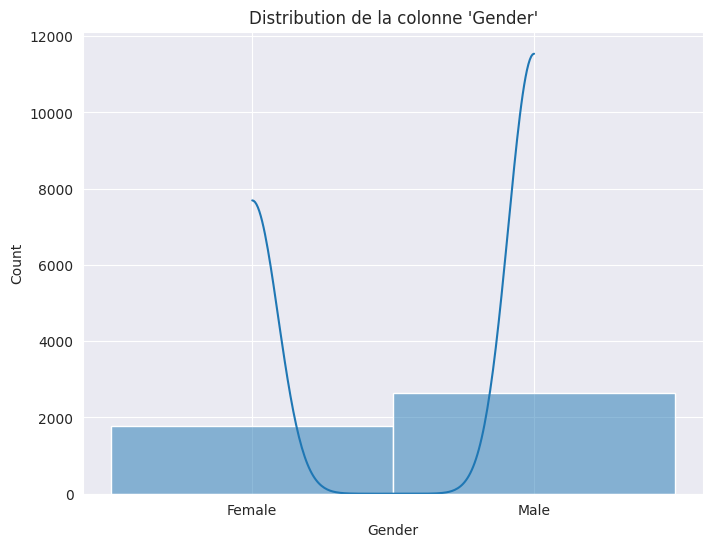

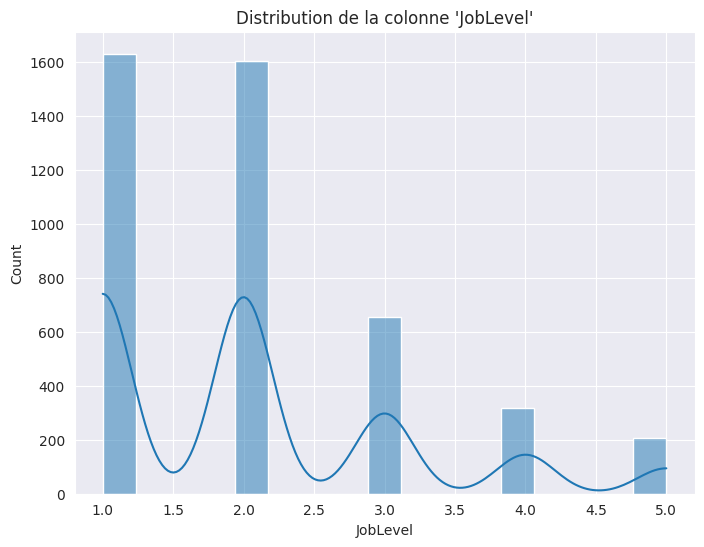

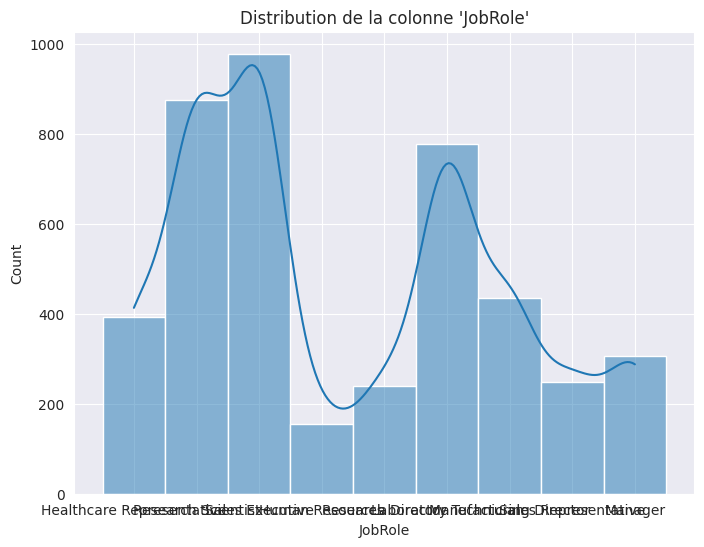

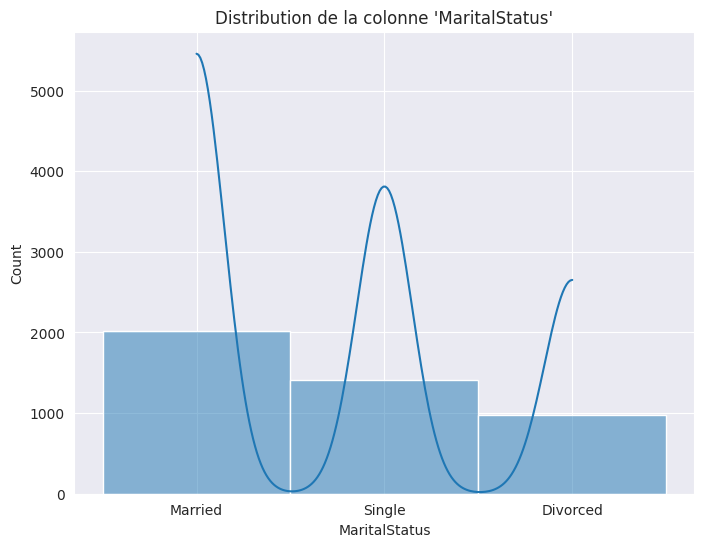

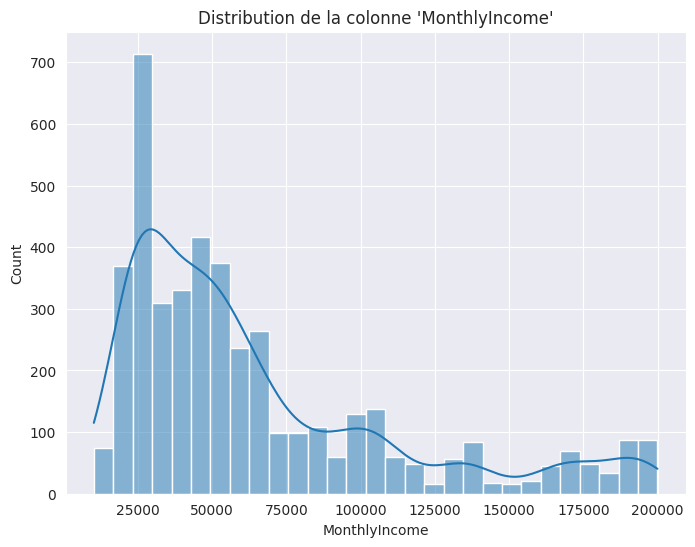

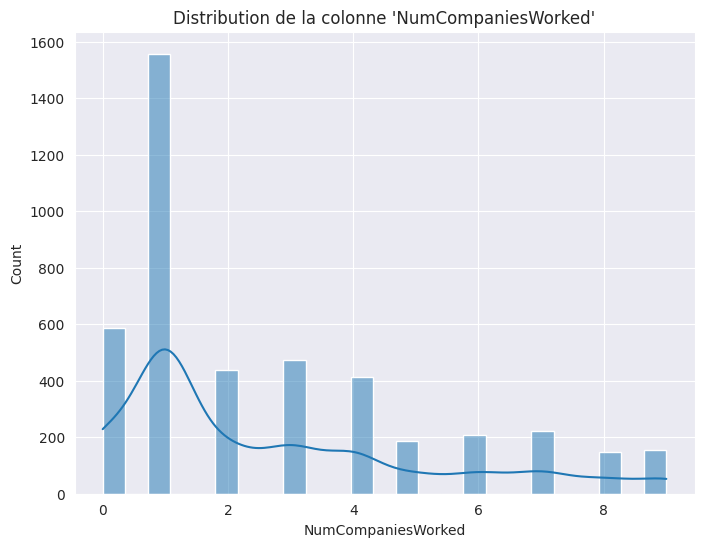

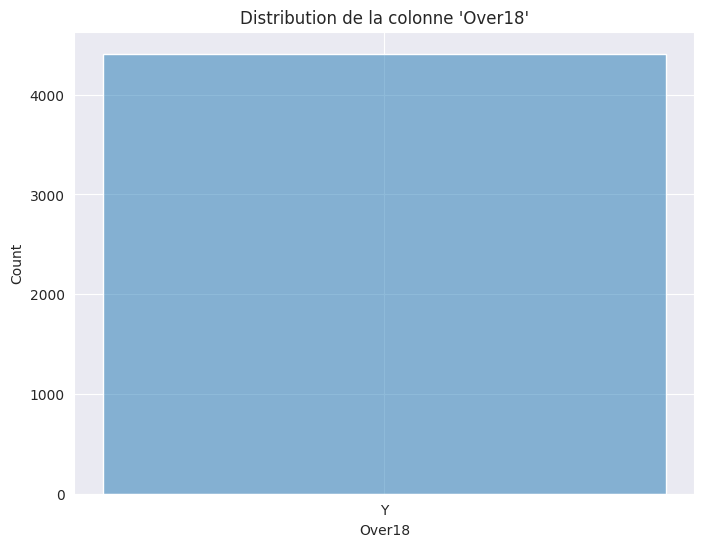

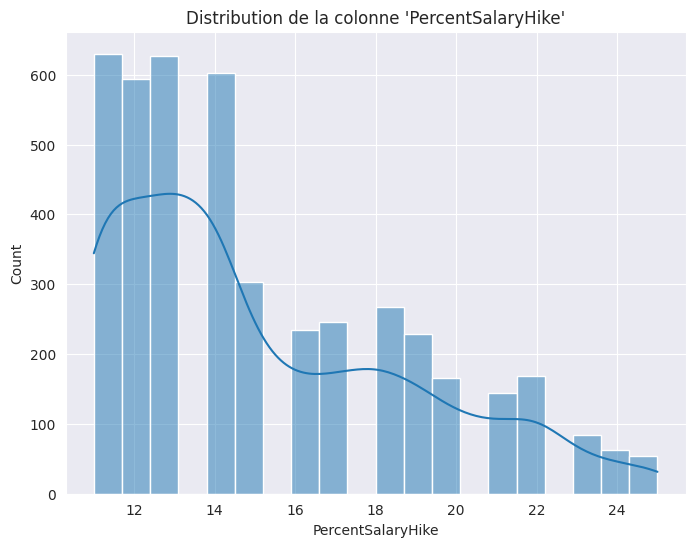

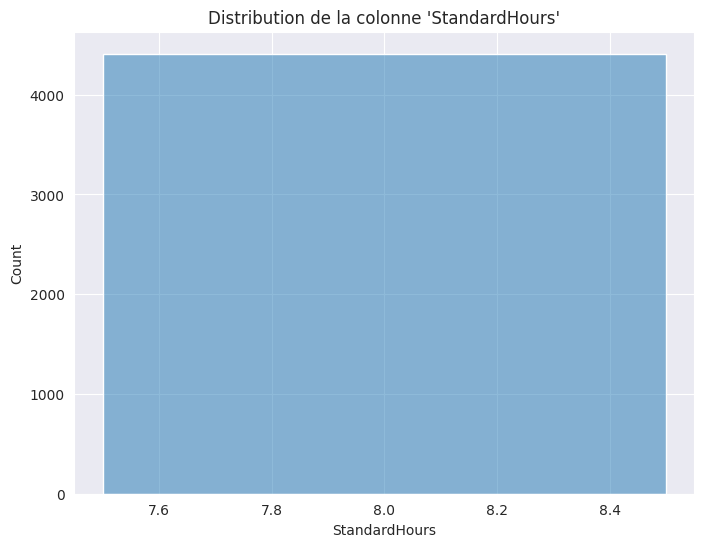

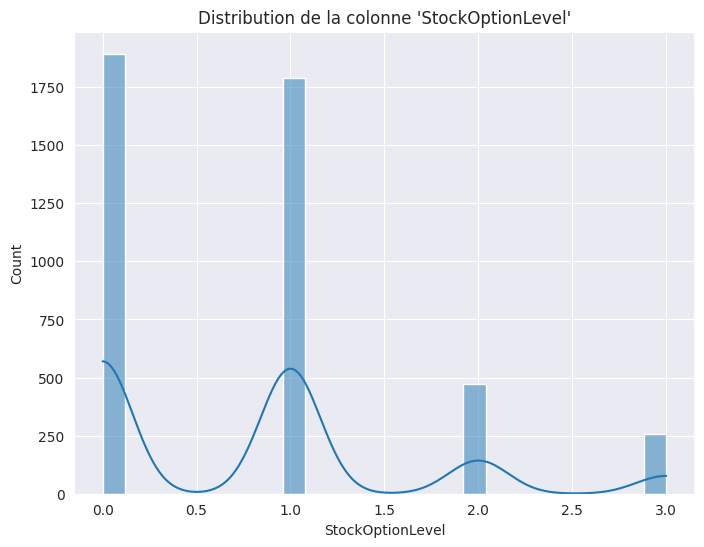

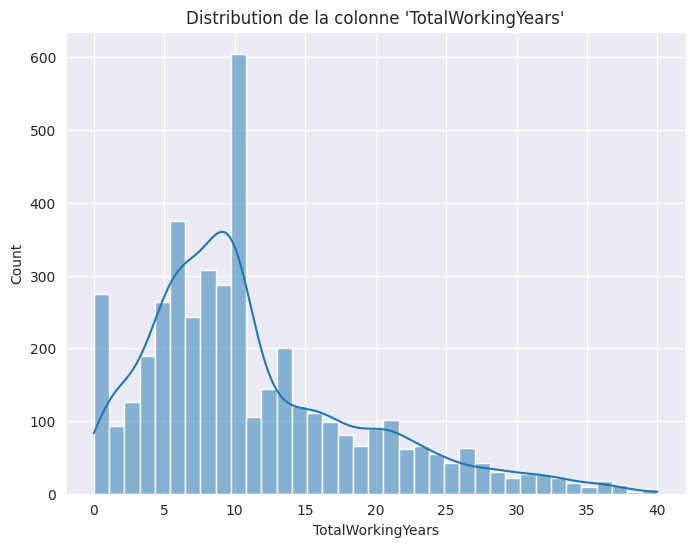

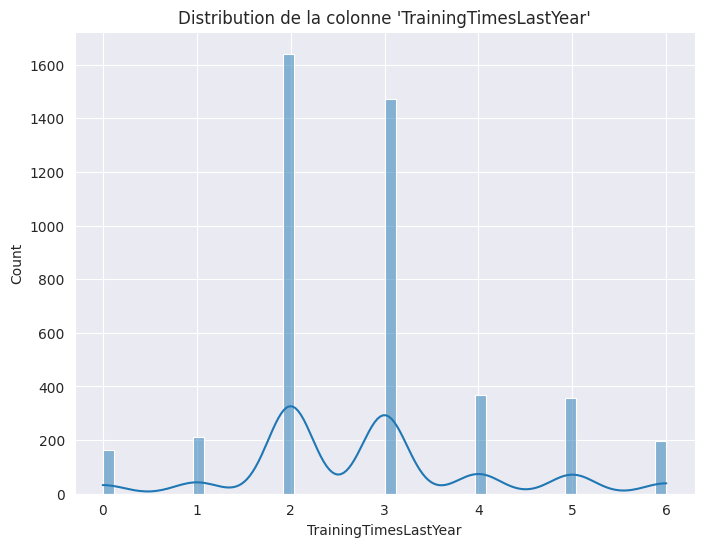

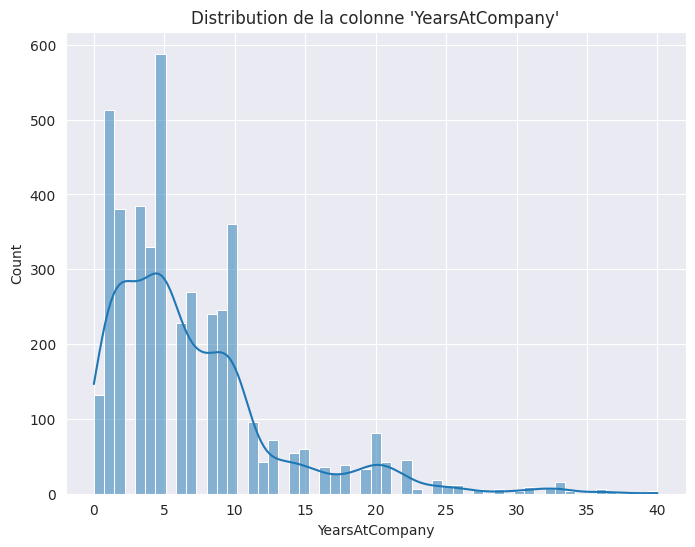

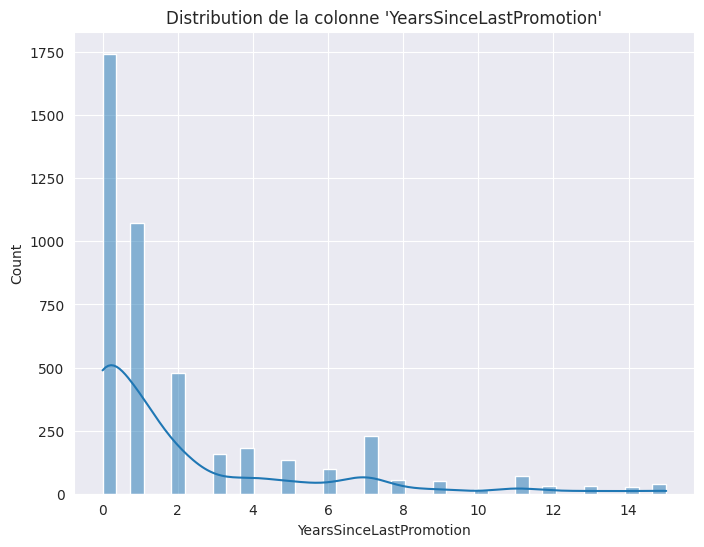

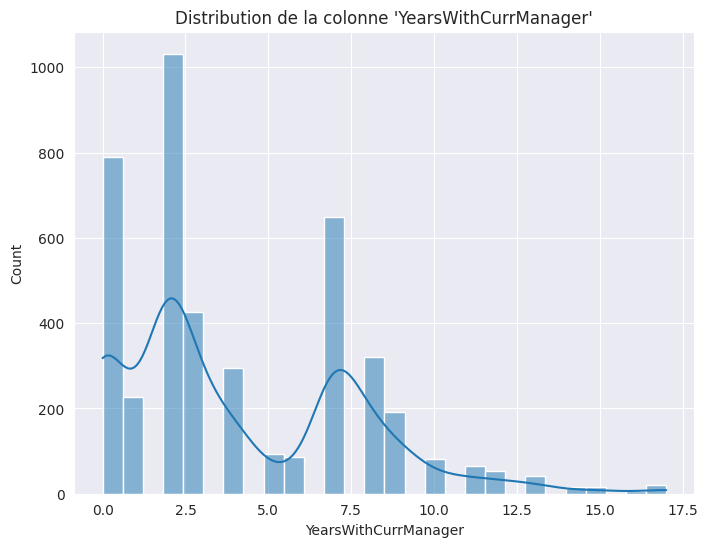

In [ ]:
for col in df_general.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(df_general[col], kde=True)
    plt.title(f"Distribution de la colonne '{col}'")

    plt.show()

## 4.5) Nombre de valeurs par état d'attrition

In [ ]:
print("=== Nombre de valeurs par état d'attrition ===")
print(df_general['Attrition'].value_counts())

=== Nombre de valeurs par état d'attrition ===
Attrition
No     3699
Yes     711
Name: count, dtype: int64


## 4.6) Affichage des données manquantes

In [ ]:
# On peut afficher le nombre de valeurs manquantes par colonne
print("=== Nombre de valeurs manquantes par colonne (General Data) ===")
for df in [df_general, df_emp_survey, df_mgr_survey, df_in_time, df_out_time]:
    for col in df.columns:
        print(f"{col} : {df[col].isnull().sum()} valeurs manquantes")

=== Nombre de valeurs manquantes par colonne (General Data) ===
Age : 0 valeurs manquantes
Attrition : 0 valeurs manquantes
BusinessTravel : 0 valeurs manquantes
Department : 0 valeurs manquantes
DistanceFromHome : 0 valeurs manquantes
Education : 0 valeurs manquantes
EducationField : 0 valeurs manquantes
EmployeeCount : 0 valeurs manquantes
EmployeeID : 0 valeurs manquantes
Gender : 0 valeurs manquantes
JobLevel : 0 valeurs manquantes
JobRole : 0 valeurs manquantes
MaritalStatus : 0 valeurs manquantes
MonthlyIncome : 0 valeurs manquantes
NumCompaniesWorked : 19 valeurs manquantes
Over18 : 0 valeurs manquantes
PercentSalaryHike : 0 valeurs manquantes
StandardHours : 0 valeurs manquantes
StockOptionLevel : 0 valeurs manquantes
TotalWorkingYears : 9 valeurs manquantes
TrainingTimesLastYear : 0 valeurs manquantes
YearsAtCompany : 0 valeurs manquantes
YearsSinceLastPromotion : 0 valeurs manquantes
YearsWithCurrManager : 0 valeurs manquantes
EmployeeID : 0 valeurs manquantes
EnvironmentSati

# 5) Fusion des données
## 5.1) Merge general_data, employee_survey_data et manager_survey_data

In [ ]:
df_merged = pd.merge(df_general, df_emp_survey, on="EmployeeID")
df_merged = pd.merge(df_merged, df_mgr_survey, on="EmployeeID")

## 5.2) Calculer le nombre d'heures travaillées par jour
On va aussi créer des features à partir de df_in_time et df_out_time (par exemple : nombre d'heures travaillées moyennes). </br>
Les colonnes de in_time / out_time sont des dates/heures pour chaque jour travaillé.

In [ ]:
#  - Pour chaque employé, on peut calculer la différence out_time - in_time (en heures) pour chaque jour.
#  - Ensuite on peut faire la moyenne sur toutes les dates disponibles pour obtenir "moyenne d'heures/jour"

# Replace Unnamed header by EmployeeID
df_in_time.rename(columns={"Unnamed: 0": "EmployeeID"}, inplace=True)
df_out_time.rename(columns={"Unnamed: 0": "EmployeeID"}, inplace=True)

# Suppression de la première colonne "EmployeeID" pour faciliter les opérations (on la conserve à part)
df_in_time_id = df_in_time['EmployeeID']
df_out_time_id = df_out_time['EmployeeID']

# On exclut la colonne 'EmployeeID' des dataframes pour ne traiter que les colonnes date/heure
df_in_time_dates = df_in_time.drop(['EmployeeID'], axis=1)
df_out_time_dates = df_out_time.drop(['EmployeeID'], axis=1)

# Conversion des valeurs string en datetime pour permettre la soustraction des temps
# Nota : Certaines valeurs sont "NA" => conversion en NaT
df_in_time_dates = df_in_time_dates.apply(pd.to_datetime, errors='coerce')
df_out_time_dates = df_out_time_dates.apply(pd.to_datetime, errors='coerce')

# Calcul de la différence (out_time - in_time) par employé et par jour
df_hours = df_out_time_dates - df_in_time_dates  # Résultat en format timedelta

# Convertir les timedelta en nombre d'heures (float)
df_hours = df_hours.apply(lambda x: x.dt.total_seconds() / 3600)

# Exemple : Calcul d'une statistique agrégée (moyenne d'heures/jour travaillé) pour chaque employé
df_hours_mean = df_hours.mean(axis=1)

# On veut garder la différence entre StandardHours et mean_work_hours
df_hours['mean_work_hours_diff'] = df_hours_mean - df_merged['StandardHours']

# On peut aussi calculer le nombre de jours d'absence (journées entières manquantes => in_time = NA & out_time = NA)
# ou le ratio de jours travaillés vs le total possible, etc.
# Ci-dessous un exemple de calcul du nombre de jours (colonnes) pour lesquels l'entrée est manquante
nb_jours_total = df_hours.shape[1] - 1  # -1 car la dernière colonne est 'mean_work_hours' qu'on vient d'ajouter
df_hours['absent_days'] = df_hours.iloc[:, :-1].isna().sum(axis=1)  # On ne compte pas la col. 'mean_work_hours'

# Concaténer EmployeeID pour pouvoir refusionner
df_hours_final = pd.concat([df_in_time_id, df_hours[['mean_work_hours_diff','absent_days']]], axis=1)

# Heure d'arrivé moyenne
df_hours_final['Avg_Hours_In'] = df_in_time_dates.apply(
    lambda row: row.dropna().dt.hour.mean() + row.dropna().dt.minute.mean() / 60
    if not row.dropna().empty else None, axis=1
)

# Heure de départ moyenne
df_hours_final['Avg_Hours_Out'] = df_out_time_dates.apply(
    lambda row: row.dropna().dt.hour.mean() + row.dropna().dt.minute.mean() / 60
    if not row.dropna().empty else None, axis=1
)

## 5.3) Merge avec df_merged pour rajouter ces nouvelles features

In [ ]:
df_merged = pd.merge(df_merged, df_hours_final, on='EmployeeID', how='left')

print("\n=== Aperçu des données fusionnées ===\n")
print(df_merged.head())
print(df_merged.info())


=== Aperçu des données fusionnées ===

   Age Attrition     BusinessTravel              Department  DistanceFromHome  \
0   51        No      Travel_Rarely                   Sales                 6   
1   31       Yes  Travel_Frequently  Research & Development                10   
2   32        No  Travel_Frequently  Research & Development                17   
3   38        No         Non-Travel  Research & Development                 2   
4   32        No      Travel_Rarely  Research & Development                10   

   Education EducationField  EmployeeCount  EmployeeID  Gender  ...  \
0          2  Life Sciences              1           1  Female  ...   
1          1  Life Sciences              1           2  Female  ...   
2          4          Other              1           3    Male  ...   
3          5  Life Sciences              1           4    Male  ...   
4          1        Medical              1           5    Male  ...   

   YearsWithCurrManager EnvironmentSatisfactio

# Analyse de la distribution normale des données

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

def plot_normal_distribution(df, column_name, log_transform=False, log_base='10'):
    """
    Trace un histogramme (densité) de la colonne `column_name` d'un DataFrame `df`
    et superpose la courbe de la distribution normale basée sur la moyenne et
    l'écart-type (sur données brutes ou log-transformées).

    Paramètres:
    -----------
    df : pd.DataFrame
        Votre DataFrame
    column_name : str
        Nom de la colonne à tracer
    log_transform : bool
        Si True, applique un log sur les valeurs de la colonne avant le tracé.
    log_base : str
        - '10' pour un log base 10 (log10)
        - 'e' pour un log naturel (ln)
    """
    data = df[column_name].dropna()

    if log_transform:
        if log_base == '10':
            data = np.log10(data + 1)
            suffix = " (log10)"
        elif log_base == 'e':
            data = np.log(data + 1)
            suffix = " (ln)"
        else:
            raise ValueError("log_base doit être '10' ou 'e'")
    else:
        suffix = ""


    mean = data.mean()
    std = data.std()

    x_min = mean - 3 * std
    x_max = mean + 3 * std

    if x_min == x_max:
        x_min = mean - 1
        x_max = mean + 1

    x = np.linspace(x_min, x_max, 200)

    pdf = norm.pdf(x, mean, std)
    plt.figure(figsize=(8, 6))
    sns.histplot(data, kde=False, stat='density', bins=30, color='skyblue', label='Données')

    plt.plot(x, pdf, color='red', linewidth=2, label='Distribution normale')
    plt.xlim(x_min, x_max)

    plt.title(f"Distribution de la colonne: {column_name}{suffix}")
    plt.xlabel(f"{column_name}{suffix}")
    plt.ylabel("Densité")
    plt.legend()

    plt.show()


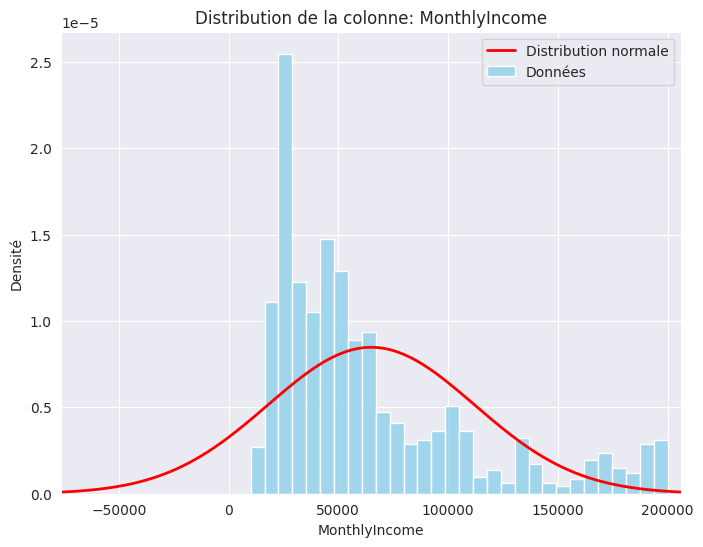

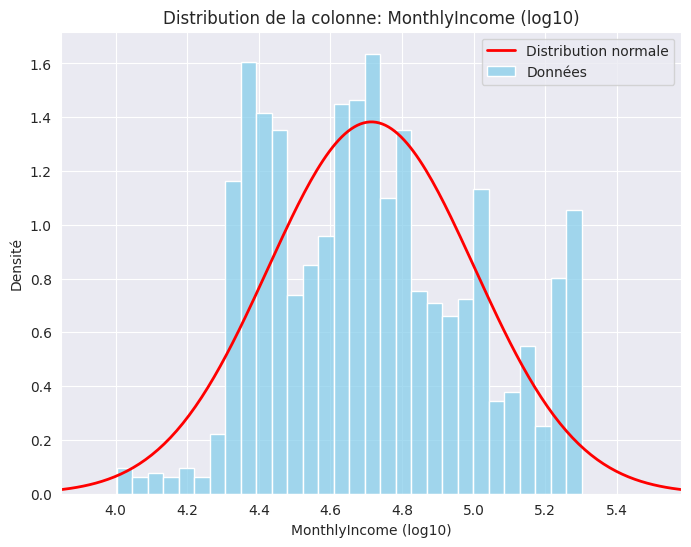

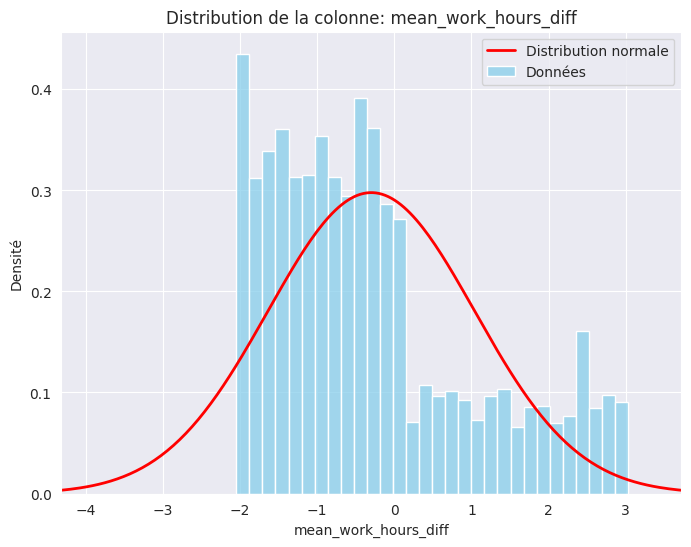

In [ ]:
plot_normal_distribution(df_merged, 'MonthlyIncome', log_transform=False)
plot_normal_distribution(df_merged, 'MonthlyIncome', log_transform=True, log_base='10')
plot_normal_distribution(df_merged, 'mean_work_hours_diff', log_transform=False, log_base='10')

# 6) Nettoyage et préparation des données
## 6.1) Gérer les valeurs manquantes

In [ ]:
# On regarde déjà combien de valeurs manquantes par colonne
missing_values = df_merged.isnull().sum()
print("\n=== Nombre de valeurs manquantes par colonne ===\n", missing_values)


=== Nombre de valeurs manquantes par colonne ===
 Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
JobInvolvement              0
PerformanceRating           0
mean_work_hours_diff        0
absent_days                 0
Avg_Hours_In       

In [ ]:
# Dropna sur la colonne Attrition car c'est notre target
df_merged = df_merged.dropna(subset=['Attrition'])

In [ ]:
# Exemple d'imputation : pour 'mean_work_hours' et 'absent_days', on remplace les NaN par la moyenne
# On privilégie la moyenne ici car les valeurs de type durée (heures) ne sont pas fortement bornées
df_merged['mean_work_hours_diff'] = df_merged['mean_work_hours_diff'].fillna(df_merged['mean_work_hours_diff'].mean())
print(f"Filled missing values for column 'mean_work_hours_diff' with mean value {df_merged['mean_work_hours_diff'].mean()}")
df_merged['absent_days'] = df_merged['absent_days'].fillna(df_merged['absent_days'].mean())
print(f"Filled missing values for column 'absent_days' with mean value {df_merged['absent_days'].mean()}")

Filled missing values for column 'mean_work_hours_diff' with mean value -0.2992082155218533
Filled missing values for column 'absent_days' with mean value 24.73469387755102


In [ ]:
# Pour les colonnes de satisfaction ou autres colonnes numériques manquantes, on peut aussi faire un fillna
# On privilégie la médiane
num_cols = ['EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
            'JobInvolvement', 'PerformanceRating', 'TotalWorkingYears', 'NumCompaniesWorked',]
for col in num_cols:
    if col in df_merged.columns:
        df_merged[col] = df_merged[col].fillna(df_merged[col].median())
        print(f"Filled missing values for column {col} with median value {df_merged[col].median()}")


Filled missing values for column EnvironmentSatisfaction with median value 3.0
Filled missing values for column JobSatisfaction with median value 3.0
Filled missing values for column WorkLifeBalance with median value 3.0
Filled missing values for column JobInvolvement with median value 3.0
Filled missing values for column PerformanceRating with median value 3.0
Filled missing values for column TotalWorkingYears with median value 10.0
Filled missing values for column NumCompaniesWorked with median value 2.0


## 6.2) Nettoyage de certaines colonnes (ex: Over18, EmployeeCount, StandardHours)

In [ ]:
# On remarque souvent dans ce dataset "EmployeeCount" est toujours 1 => pas d'intérêt
# "Over18" est toujours "Y", "StandardHours" est souvent 8 => on peut les drop
cols_to_drop = ['Over18','StandardHours','EmployeeCount']
for c in cols_to_drop:
    if c in df_merged.columns:
        df_merged.drop(c, axis=1, inplace=True, errors='ignore')

## 6.3) Conversion de colonnes catégorielles en numériques

In [ ]:
# Par exemple, Attrition = Yes/No, Gender = Male/Female, etc.
# On peut les encoder, soit via LabelEncoder, soit via OneHotEncoder
# Commençons par un label encoding simple pour la variable cible

df_merged['Attrition'] = df_merged['Attrition'].map({'Yes':1, 'No':0})

# Autres colonnes catégorielles (BusinessTravel, Department, EducationField, Gender, MaritalStatus, JobRole...)
cat_cols = ['BusinessTravel','Department','EducationField','Gender','MaritalStatus','JobRole']

# On va faire un one-hot-encoding rapide:
df_merged = pd.get_dummies(df_merged, columns=cat_cols, drop_first=True)

# 7) Séparation des données en train/test

In [ ]:
# On sépare la cible (Attrition) des features

X = df_merged.drop(['EmployeeID','Attrition'], axis=1)
y = df_merged['Attrition']

# Ensuite on fait un split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 8) scaling et entraînements

In [ ]:
# Selon le modèle (Logistic Regression par exemple), il peut être intéressant de standardiser
# Ici on va montrer un exemple de pipeline manuel (scaling + logistic regression).

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 8.1) Fonctions support pour les tests

In [ ]:
# Fonction pour afficher la matrice de confusion
def plotGridCV(grid, param_name, param_value, index, columns, values, title, ylabel, xlabel):
    # Affichage du graphique
    results = pd.DataFrame(grid.cv_results_)
    df = results[ results[param_name] == param_value ]
    pivot = df.pivot(
        index=index,
        columns=columns,
        values=values
    )

    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot, annot=True, cmap='coolwarm')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()

def getBestModelWithGridCV(model_, param_grid):
    grid = GridSearchCV(
        estimator=model_,
        param_grid=param_grid,
        scoring='accuracy',        # ou 'roc_auc'
        cv=5,                      # 5 folds
        verbose=1,                 # pour voir la progression
        n_jobs=-1                  # utilise tous les coeurs dispo
    )

    # Entraînement du GridSearchCV
    grid.fit(X_train_scaled, y_train)

    # Récupération des meilleurs paramètres et score
    print("=== Logistic Regression - Meilleurs hyperparamètres ===")
    print("Best Params :", grid.best_params_)
    print("Best Score  :", grid.best_score_)

    best_model = grid.best_estimator_

    return best_model, grid

def predict(best_model):
    y_pred_best = best_model.predict(X_test_scaled)
    y_proba_best = best_model.predict_proba(X_test_scaled)[:,1]

    print("\n=== Évaluation sur le jeu de test (LogisticRegression avec meilleurs params) ===")
    print("Accuracy :", accuracy_score(y_test, y_pred_best))
    print("ROC AUC  :", roc_auc_score(y_test, y_proba_best))
    print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_best))
    print("Classification report :\n", classification_report(y_test, y_pred_best))

    return y_pred_best, y_proba_best


## 8.2) Entrainement d'un modèle de Logistic Regression et Arbre de décision
On peut constater que les résultats sont prométeurs pour le modèle d'arbre de décision. Nous pouvons toutefois effectuer une phase de tuning pour améliorer les performances en trouvant les meilleurs hyperparamètres.

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=500),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    predict(model)


=== Évaluation sur le jeu de test (LogisticRegression avec meilleurs params) ===
Accuracy : 0.8571428571428571
ROC AUC  : 0.8035359302964937
Matrice de confusion :
 [[1077   33]
 [ 156   57]]
Classification report :
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      1110
           1       0.63      0.27      0.38       213

    accuracy                           0.86      1323
   macro avg       0.75      0.62      0.65      1323
weighted avg       0.83      0.86      0.83      1323


=== Évaluation sur le jeu de test (LogisticRegression avec meilleurs params) ===
Accuracy : 0.9523809523809523
ROC AUC  : 0.9109186651440172
Matrice de confusion :
 [[1079   31]
 [  32  181]]
Classification report :
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1110
           1       0.85      0.85      0.85       213

    accuracy                           0.95      1323
   macro avg       

## 8.3) Tuning des hyperparamètres pour les modèles de Logistic Regression et Arbre de décision
Pour chaque modèle, on va utiliser GridSearchCV pour trouver les meilleurs hyperparamètres. </br>
Nous remarquons que pour la régression logistique, les meilleurs hyperparamètres sont C=0.01, max_iter=100 et solver='lbfgs' avec un score de 0.85. </br>
Pour l'arbre de décision, les meilleurs hyperparamètres sont criterion='entropy', max_depth=20 et min_samples_split=2 avec un score de 0.93.

Pour améliorer les performances, nous pouvons utiliser des ensembles de modèles (Random Forest, Gradient Boosting, etc.) ou des méthodes de stacking.

### 8.3.1) Logistic Regression

#### 8.3.1.1) Modèle de Régression Logistique  

La régression logistique prédit une **probabilité** d'appartenance à une classe (0 ou 1) via une **fonction sigmoïde** :

$$
P(y = 1 | X) = \sigma(wX + b)
$$

où :
- \( P(y = 1 | X) \) est la **probabilité** que la classe soit 1,  
- \( X \) est le **vecteur des features**,  
- \( w \) est le **vecteur des coefficients du modèle**,  
- \( b \) est le **biais (intercept)**,  
- \( \sigma(z) \) est la **fonction sigmoïde** définie par :  

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

---

#### 8.3.1.2) Fonction Coût (Log-Loss)  

L'optimisation du modèle repose sur la **minimisation de l'entropie croisée**, aussi appelée **log-loss** :

$$
J(w, b) = - \frac{1}{m} \sum_{i=1}^{m} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
$$

avec :
- \( \hat{y}_i = \sigma(wX_i + b) \) la **prédiction du modèle**,  
- \( y_i \) la **valeur réelle** (0 ou 1),  
- \( m \) le **nombre total d'échantillons**.  

**But : minimiser cette fonction coût pour obtenir les meilleurs coefficients.**  

---

#### 8.3.1.3) Optimisation : Descente de Gradient  

Les **dérivées partielles** de la fonction coût permettent d’ajuster les paramètres du modèle :  

$$
\frac{\partial J}{\partial w} = \frac{1}{m} \sum_{i=1}^{m} ( \sigma(wX_i + b) - y_i ) X_i
$$

$$
\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} ( \sigma(wX_i + b) - y_i )
$$

**Mise à jour des paramètres :**  

$$
w = w - \eta \frac{\partial J}{\partial w}
$$

$$
b = b - \eta \frac{\partial J}{\partial b}
$$

où :
- \( \eta \) (learning rate) contrôle la **vitesse d'apprentissage**.

---

#### 8.3.1.4) Application au Code  

**GridSearchCV** optimise plusieurs hyperparamètres pour ajuster la **régression logistique** :  

##### • Coefficient de Régularisation (\( C \))  

Le paramètre \( C \) contrôle la **force de la régularisation** appliquée aux coefficients du modèle.  
Il est **inversement proportionnel** au terme de régularisation \( \lambda \) :

$$
\lambda = \frac{1}{C}
$$

- Si **\( C \) est grand**, la régularisation est **faible**, et le modèle risque de **sur-apprendre** (*overfitting*).  
- Si **\( C \) est petit**, la régularisation est **forte**, ce qui **simplifie le modèle** mais peut entraîner une **sous-apprentissage** (*underfitting*).  

---

##### • Solveur (`solver`)  

Le solveur est l’algorithme utilisé pour **optimiser les coefficients** de la régression logistique.  
GridSearchCV teste différentes méthodes :

- `'liblinear'` → adapté aux **petits datasets**, supporte **L1 et L2** comme pénalités.  
- `'lbfgs'` → plus rapide pour **L2**, recommandé pour **grands datasets**.  

💡 **Remarque :**  
- Pour **L1**, il faut utiliser `'liblinear'` car `'lbfgs'` ne le supporte pas.  
- Pour **L2**, les deux solveurs sont compatibles.  

---

##### • Nombre d’itérations (`max_iter`)  

Ce paramètre définit **combien de fois** l’algorithme met à jour les coefficients \( w \) et \( b \) :

- **Si `max_iter` est trop faible**, la convergence peut être **incomplète**.  
- **Si `max_iter` est trop grand**, cela **ralentit l'entraînement** sans réel bénéfice.  



Fitting 5 folds for each of 30 candidates, totalling 150 fits
=== Logistic Regression - Meilleurs hyperparamètres ===
Best Params : {'C': 0.1, 'max_iter': 100, 'solver': 'lbfgs'}
Best Score  : 0.8571425574210739

=== Évaluation sur le jeu de test (LogisticRegression avec meilleurs params) ===
Accuracy : 0.854875283446712
ROC AUC  : 0.8018229497102736
Matrice de confusion :
 [[1077   33]
 [ 159   54]]
Classification report :
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      1110
           1       0.62      0.25      0.36       213

    accuracy                           0.85      1323
   macro avg       0.75      0.61      0.64      1323
weighted avg       0.83      0.85      0.83      1323



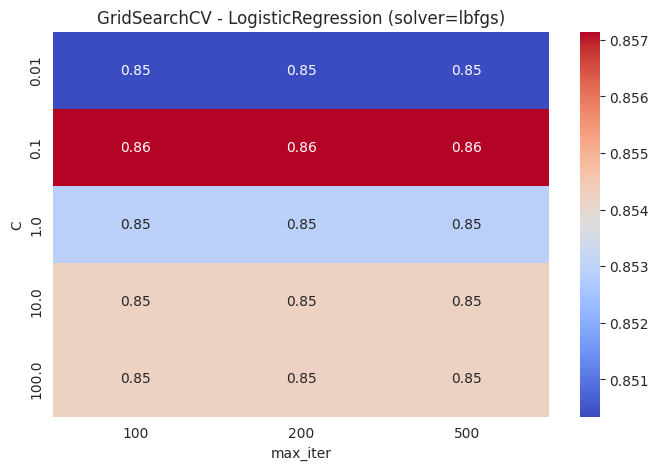

In [ ]:
# Exemple de grille de paramètres (simple).
# Attention : certaines combinaisons penalty/solver peuvent être incompatibles.
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],         # Coefficient de régularisation
    'solver': ['liblinear', 'lbfgs'],     # Solveur
    'max_iter': [100, 200, 500]           # Nombre itérations max
    # 'penalty': ['l1','l2']  # <--- l1 nécessite solver='liblinear';
                              #      si on veut tester l1, il faut ajuster la grille
}

# Création de l'instance LogisticRegression
lr_model = LogisticRegression(random_state=42)

# GridSearchCV : 5-fold cross-validation, scoring basé sur l'accuracy (ou 'roc_auc', etc.)
best_lr, grid_lr = getBestModelWithGridCV(lr_model, param_grid_lr)

# On peut maintenant re-prédire sur le test set avec le meilleur modèle trouvé
y_pred_best_lr, y_proba_best_lr = predict(best_lr)

# Affichage du graphique
plotGridCV(grid_lr, 'param_solver', 'lbfgs', 'param_C', 'param_max_iter', 'mean_test_score', 'GridSearchCV - LogisticRegression (solver=lbfgs)', 'C', 'max_iter')

### 8.3.2) Decision Tree

#### 8.3.2.1) Modèle de l'Arbre de Décision  

L'**arbre de décision** est un modèle d’apprentissage supervisé qui partitionne l’espace des features en sous-ensembles pour prédire une classe.  

Le modèle est basé sur une **séquence de décisions conditionnelles**, organisées en **nœuds** :  
- **Racine** : Feature de départ choisie.  
- **Noeuds internes** : Tests basés sur une feature.  
- **Feuilles** : Classes de sortie (prédictions).  

Le critère d’un **bon split** est déterminé par une **fonction d’impureté** telle que **l’indice de Gini** ou **l’entropie**.  

---

#### 8.3.2.2) Fonctions de Séparation (Impureté)  

##### • Indice de Gini  

L’indice de Gini mesure **l’impureté** d’un nœud.  
Il est défini comme :

$$
Gini(t) = 1 - \sum_{i=1}^{c} p_i^2
$$

où :
- \( c \) est le nombre de classes,  
- \( p_i \) est la proportion d’éléments appartenant à la classe \( i \) dans le nœud \( t \).  

Si un nœud est **pur** (tous les éléments sont de la même classe), alors \( Gini = 0 \).  

---

##### • Entropie  

L’**entropie** est une autre mesure d’impureté, inspirée de la théorie de l'information :

$$
H(t) = - \sum_{i=1}^{c} p_i \log_2 p_i
$$

Si un nœud est **parfaitement homogène**, alors \( H = 0 \).  
Si les classes sont **équilibrées**, l'entropie est **maximale**.  

**Différence entre Gini et Entropie** :  
- **Gini** est plus rapide à calculer.  
- **Entropie** est plus théorique et favorise les séparations équilibrées.  

---

#### 8.3.2.3) Algorithme d’Optimisation  

L'arbre de décision sélectionne à chaque étape la **feature et le seuil** qui **minimisent l’impureté**.  
Le critère est :  

$$
Gain = Impureté_{parent} - \sum_{j=1}^{k} \frac{n_j}{n} Impureté_j
$$

où :
- \( n_j \) est le nombre d’observations dans le sous-noeud \( j \),  
- \( n \) est le nombre total d’observations du noeud parent.  

L’algorithme **itère** jusqu’à ce qu’un **critère d’arrêt** soit atteint :

- **Profondeur maximale (`max_depth`)**  
- **Nombre minimum d’échantillons pour un split (`min_samples_split`)**  

---

#### 8.3.2.4) Application au Code  

**GridSearchCV** optimise plusieurs **hyperparamètres** pour ajuster l'arbre de décision :  

##### • Profondeur de l’Arbre (`max_depth`)  

La **profondeur** contrôle la complexité du modèle :  
- **Profondeur élevée** → Plus de règles, risque de **sur-apprentissage** (*overfitting*).  
- **Profondeur faible** → Moins de flexibilité, risque de **sous-apprentissage** (*underfitting*).  

---

##### • Nombre Minimum d'Échantillons pour un Split (`min_samples_split`)  

Ce paramètre définit combien d’échantillons sont nécessaires pour **diviser un nœud** :  
- Valeur faible (\(2, 5\)) → **Arbre complexe**, risque de **sur-ajustement**.  
- Valeur élevée (\(10\)) → **Arbre plus simple**, réduit l'**overfitting**.  

---

##### • Critère de Séparation (`criterion`)  

Le code teste **deux méthodes** :
- `'gini'` → Utilise l'**indice de Gini**.  
- `'entropy'` → Utilise l'**entropie de Shannon**.  

**Remarque** : En général, **les deux donnent des résultats similaires**.  


Fitting 5 folds for each of 24 candidates, totalling 120 fits
=== Logistic Regression - Meilleurs hyperparamètres ===
Best Params : {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}
Best Score  : 0.9329409975190529

=== Évaluation sur le jeu de test (LogisticRegression avec meilleurs params) ===
Accuracy : 0.9727891156462585
ROC AUC  : 0.9553292729349067
Matrice de confusion :
 [[1089   21]
 [  15  198]]
Classification report :
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1110
           1       0.90      0.93      0.92       213

    accuracy                           0.97      1323
   macro avg       0.95      0.96      0.95      1323
weighted avg       0.97      0.97      0.97      1323



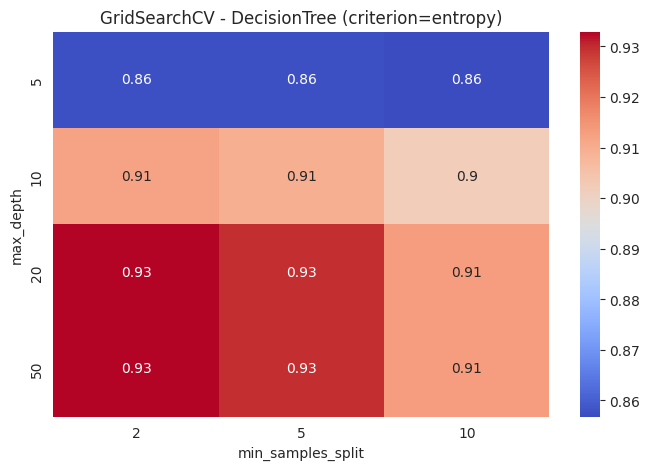

In [ ]:
# Exemple de grille de paramètres (simple)
param_grid_dt = {
    'max_depth': [5, 10, 20, 50], # Profondeur de l'arbre
    'min_samples_split': [2, 5, 10], # Nombre minimum d'échantillons pour spliter un noeud
    'criterion': ['gini', 'entropy'] # Métrique pour mesurer la qualité de la split
}

dt_model = DecisionTreeClassifier(random_state=42)

best_dt, grid_dt = getBestModelWithGridCV(dt_model, param_grid_dt)

# On peut maintenant re-prédire sur le test set avec le meilleur modèle trouvé
y_pred_best_dt, y_proba_best_dt = predict(best_dt)

# Affichage du graphique
plotGridCV(grid_dt, 'param_criterion', 'entropy', 'param_max_depth', 'param_min_samples_split', 'mean_test_score', 'GridSearchCV - DecisionTree (criterion=entropy)', 'max_depth', 'min_samples_split')


# 8.4) Entrainement d'ensembles de modèles
### 8.4.1) Entrainement et tuning d'un BaggingClassifier une Régression Logistique

Fitting 5 folds for each of 27 candidates, totalling 135 fits
=== Logistic Regression - Meilleurs hyperparamètres ===
Best Params : {'max_features': 1.0, 'max_samples': 0.8, 'n_estimators': 10}
Best Score  : 0.8577913801513745

=== Évaluation sur le jeu de test (LogisticRegression avec meilleurs params) ===
Accuracy : 0.854875283446712
ROC AUC  : 0.8017721947299412
Matrice de confusion :
 [[1075   35]
 [ 157   56]]
Classification report :
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      1110
           1       0.62      0.26      0.37       213

    accuracy                           0.85      1323
   macro avg       0.74      0.62      0.64      1323
weighted avg       0.83      0.85      0.83      1323



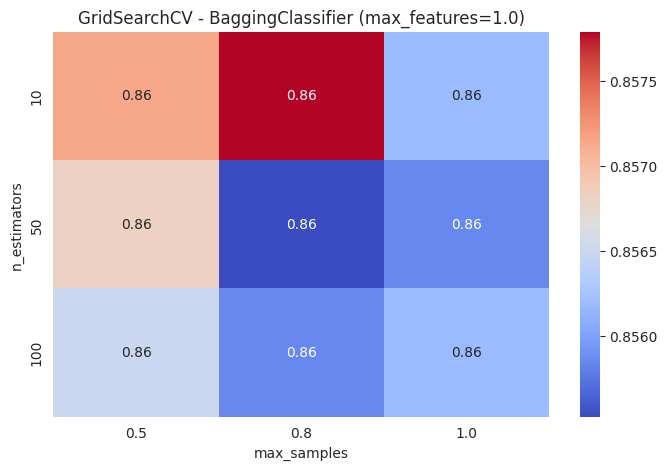

In [ ]:
# Exemple de grille de paramètres
param_grid_bagging = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [0.5, 0.8, 1.0]
}

# Création de l'instance BaggingClassifier
bagging_model = BaggingClassifier(best_lr, random_state=42)

# GridSearchCV : 5-fold cross-validation, scoring basé sur l'accuracy (ou 'roc_auc', etc.)
best_bagging, grid_bagging = getBestModelWithGridCV(bagging_model, param_grid_bagging)

# On peut maintenant re-prédire sur le test set avec le meilleur modèle trouvé
y_pred_best_bagging, y_proba_best_bagging = predict(best_bagging)

# Affichage du graphique
plotGridCV(grid_bagging, 'param_max_features', 1.0, 'param_n_estimators', 'param_max_samples', 'mean_test_score', 'GridSearchCV - BaggingClassifier (max_features=1.0)', 'n_estimators', 'max_samples')

### 8.4.2) Entrainement et tuning d'un Boosting avec un Logistic Regression

Fitting 5 folds for each of 9 candidates, totalling 45 fits
=== Logistic Regression - Meilleurs hyperparamètres ===
Best Params : {'learning_rate': 0.1, 'n_estimators': 100}
Best Score  : 0.849047746429377

=== Évaluation sur le jeu de test (LogisticRegression avec meilleurs params) ===
Accuracy : 0.8503401360544217
ROC AUC  : 0.80356130778666
Matrice de confusion :
 [[1097   13]
 [ 185   28]]
Classification report :
               precision    recall  f1-score   support

           0       0.86      0.99      0.92      1110
           1       0.68      0.13      0.22       213

    accuracy                           0.85      1323
   macro avg       0.77      0.56      0.57      1323
weighted avg       0.83      0.85      0.81      1323



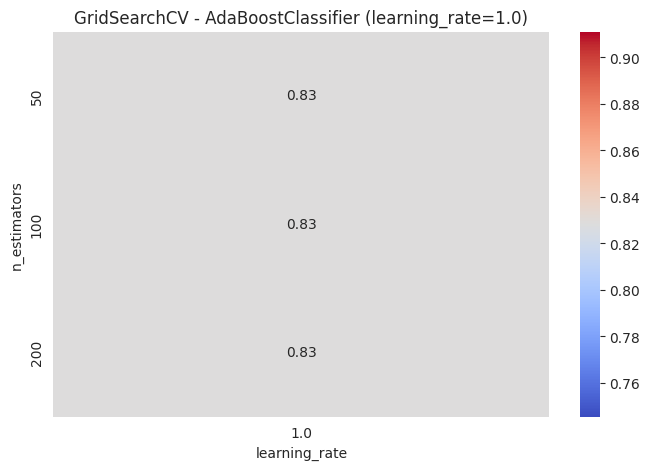

In [ ]:
# Exemple de grille de paramètres pour AdaBoost
param_grid_boosting = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
}
#
boosting_model = AdaBoostClassifier(best_lr, random_state=42)

# GridSearchCV : 5-fold cross-validation, scoring basé sur l'accuracy (ou 'roc_auc', etc.)
best_boosting, grid_boosting = getBestModelWithGridCV(boosting_model, param_grid_boosting)

# On peut maintenant re-prédire sur le test set avec le meilleur modèle trouvé
y_pred_best_boosting, y_proba_best_boosting = predict(best_boosting)

# Affichage du graphique
plotGridCV(grid_boosting, 'param_learning_rate', 1.0, 'param_n_estimators', 'param_learning_rate', 'mean_test_score', 'GridSearchCV - AdaBoostClassifier (learning_rate=1.0)', 'n_estimators', 'learning_rate')

### 8.4.3) Entrainement et tuning d'un Stacking de Logistic Regression et Decision Tree

Fitting 5 folds for each of 10 candidates, totalling 50 fits
=== Logistic Regression - Meilleurs hyperparamètres ===
Best Params : {'final_estimator__C': 1, 'stack_method': 'auto'}
Best Score  : 0.9345606940357613

=== Évaluation sur le jeu de test (LogisticRegression avec meilleurs params) ===
Accuracy : 0.9727891156462585
ROC AUC  : 0.9765046736877723
Matrice de confusion :
 [[1089   21]
 [  15  198]]
Classification report :
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1110
           1       0.90      0.93      0.92       213

    accuracy                           0.97      1323
   macro avg       0.95      0.96      0.95      1323
weighted avg       0.97      0.97      0.97      1323



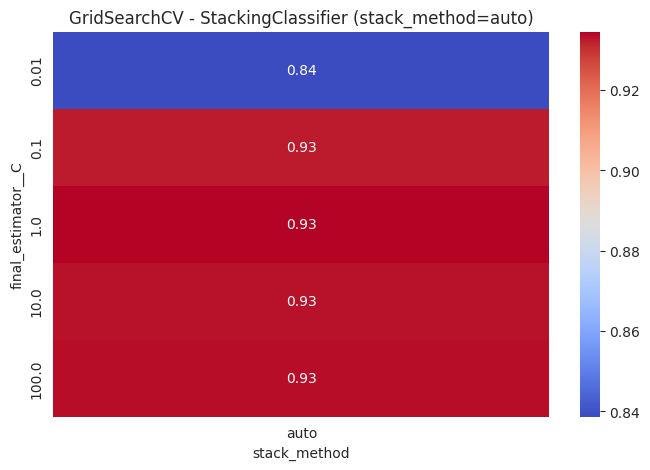

In [ ]:
# Exemple de grille de paramètres
param_grid_stacking = {
    'final_estimator__C': [0.01, 0.1, 1, 10, 100],
    'stack_method': ['auto', 'predict_proba'],
}

stacking_model = StackingClassifier(
    estimators=[('lr', best_lr), ('dt', best_dt)],
    final_estimator=LogisticRegression(random_state=42)
)

# GridSearchCV : 5-fold cross-validation, scoring basé sur l'accuracy (ou 'roc_auc', etc.)
best_stacking, grid_stacking = getBestModelWithGridCV(stacking_model, param_grid_stacking)

# On peut maintenant re-prédire sur le test set avec le meilleur modèle trouvé
y_pred_best_stacking, y_proba_best_stacking = predict(best_stacking)

# Affichage du graphique
plotGridCV(grid_stacking, 'param_stack_method', 'auto', 'param_final_estimator__C', 'param_stack_method', 'mean_test_score', 'GridSearchCV - StackingClassifier (stack_method=auto)', 'final_estimator__C', 'stack_method')


### 8.4.4) Entrainement et tuning d'un Random Forest

#### 8.4.4.1) Modèle de la Forêt Aléatoire (Random Forest)  

La **forêt aléatoire (Random Forest)** est une méthode d’apprentissage supervisé basée sur l’**agrégation de plusieurs arbres de décision**.  

**Principe :**  
1. **Création de plusieurs arbres de décision** sur des **sous-échantillons aléatoires** du dataset.  
2. **Agrégation des prédictions** de chaque arbre :  
   - Pour une **classification**, la classe majoritaire est retenue (vote majoritaire).  
   - Pour une **régression**, la moyenne des prédictions des arbres est calculée.  

**Avantages** :  
- **Réduit le sur-apprentissage** par rapport à un arbre unique.  
- **Robuste** aux variations dans les données.  
- **Gère bien les données bruitées et les variables inutiles**.  

---

#### 8.4.4.2) Importance des Features  

La forêt aléatoire évalue l’**importance des variables** en mesurant leur contribution aux décisions des arbres.  

Deux métriques courantes :  
- **Réduction moyenne de l'impureté (Gini ou Entropie)** :  
  Une feature est importante si elle permet de diviser efficacement les données dans les arbres.  
- **Importance permutationnelle** :  
  Mesure l'impact d'une feature sur la performance en **permuttant ses valeurs** et en mesurant la dégradation de la précision.  

---

#### 8.4.4.3) Hyperparamètres et Optimisation  

##### • Nombre d’arbres (`n_estimators`)  

Le nombre d’arbres dans la forêt :  
- **Petit nombre d’arbres** → Plus rapide, mais moins stable.  
- **Grand nombre d’arbres** → Plus précis, mais plus long à entraîner.  

---

##### • Profondeur maximale des arbres (`max_depth`)  

Contrôle la **complexité** de chaque arbre :  
- **Sans limite (`None`)** → Les arbres poussent jusqu’à ce que toutes les feuilles soient pures (risque de sur-apprentissage).  
- **Valeur faible (`5, 10, 20`)** → Arbres moins profonds, modèle plus simple et généralisable.  

---

##### • Nombre minimum d’échantillons pour diviser un nœud (`min_samples_split`)  

Définit combien d’échantillons sont nécessaires pour créer une nouvelle division :  
- **Valeur faible (`2`)** → Arbres plus complexes (risque de sur-apprentissage).  
- **Valeur élevée (`5, 10`)** → Réduit la complexité, améliore la généralisation.  

---

#### 8.4.4.4) Application au Code  

**GridSearchCV** optimise plusieurs **hyperparamètres** pour ajuster la forêt aléatoire :  

- `'n_estimators'`: `[50, 100, 200]`  
- `'max_depth'`: `[None, 5, 10, 20]`  
- `'min_samples_split'`: `[2, 5, 10]`  

Chaque combinaison est testée via **une validation croisée à 5 folds**.  

Fitting 5 folds for each of 36 candidates, totalling 180 fits
=== Logistic Regression - Meilleurs hyperparamètres ===
Best Params : {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best Score  : 0.9604831814867849

=== Évaluation sur le jeu de test (LogisticRegression avec meilleurs params) ===
Accuracy : 0.9758125472411187
ROC AUC  : 0.993890369242482
Matrice de confusion :
 [[1107    3]
 [  29  184]]
Classification report :
               precision    recall  f1-score   support

           0       0.97      1.00      0.99      1110
           1       0.98      0.86      0.92       213

    accuracy                           0.98      1323
   macro avg       0.98      0.93      0.95      1323
weighted avg       0.98      0.98      0.98      1323



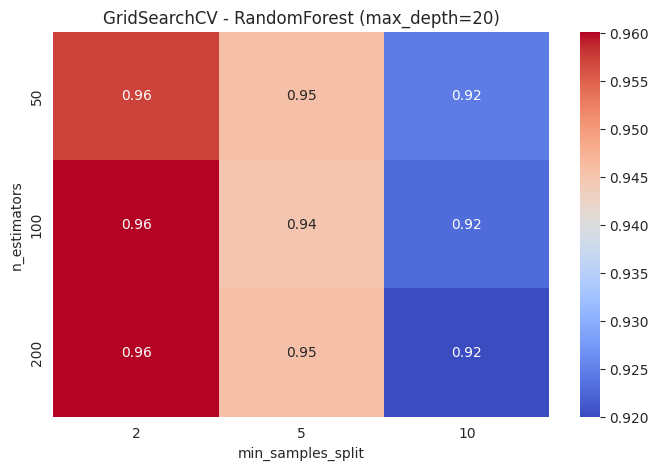

In [ ]:
# Exemple de grille de paramètres
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
    # on peut rajouter 'max_features', 'min_samples_leaf', etc. selon les besoins
}

# l'objectif du random_state est de garantir la reproductibilité des résultats. La valeur 42 est arbitraire.
rf_model = RandomForestClassifier(random_state=42, criterion= 'entropy', max_depth= 20, min_samples_split= 2)

# GridSearchCV : 5-fold cross-validation, scoring basé sur l'accuracy (ou 'roc_auc', etc.)
best_rf, grid_rf = getBestModelWithGridCV(rf_model, param_grid_rf)

# On peut maintenant re-prédire sur le test set avec le meilleur modèle trouvé
y_pred_best_rf, y_proba_best_rf = predict(best_rf)

# Affichage du graphique
plotGridCV(grid_rf, 'param_max_depth', 20, 'param_n_estimators', 'param_min_samples_split', 'mean_test_score', 'GridSearchCV - RandomForest (max_depth=20)', 'n_estimators', 'min_samples_split')


# 9) Feature importance

## 8.1) Random Forest


=== Feature importances (RandomForest) ===
 mean_work_hours_diff    0.078880
Avg_Hours_Out           0.078559
Age                     0.071745
TotalWorkingYears       0.067213
MonthlyIncome           0.057396
YearsAtCompany          0.052579
DistanceFromHome        0.041661
YearsWithCurrManager    0.040841
PercentSalaryHike       0.040362
NumCompaniesWorked      0.035171
dtype: float64


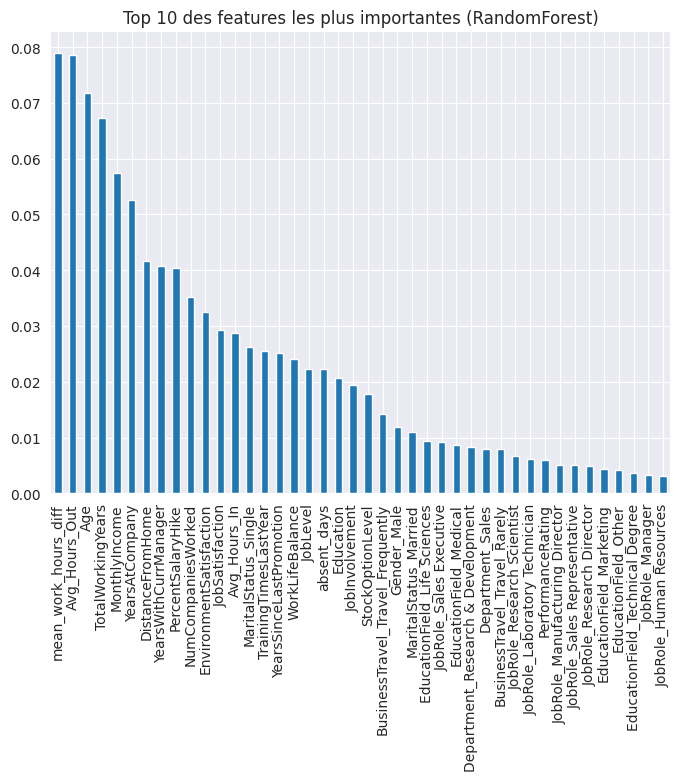

In [ ]:
# Par exemple, on peut rapidement regarder l'importance des features dans le Random Forest :
importances = best_rf.feature_importances_
feature_names = X_train.columns
feat_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("\n=== Feature importances (RandomForest) ===\n", feat_importances.head(10))

# On peut éventuellement tracer un barplot pour visualiser
plt.figure(figsize=(8,6))
feat_importances.plot(kind='bar')
plt.title("Top 10 des features les plus importantes (RandomForest)")
plt.show()


# 10) Courbe ROC

Nous pouvons constater que la courbe ROC a de bonnes performances pour le modèle Random Forest.

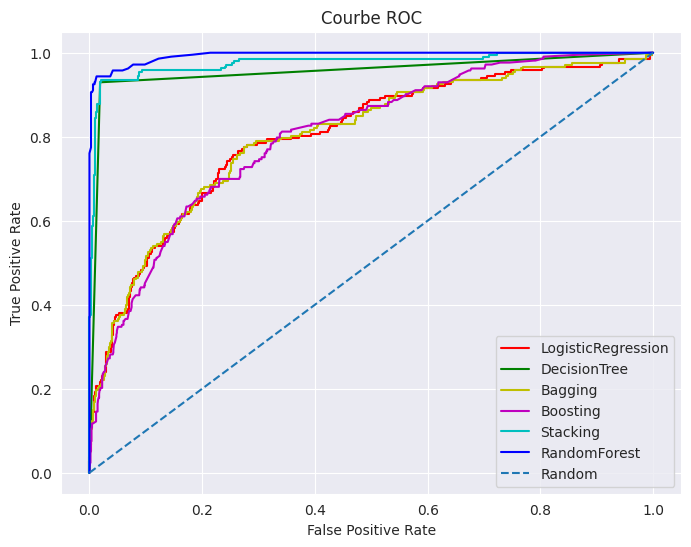

In [ ]:
# On peut aussi tracer la courbe ROC
from sklearn.metrics import roc_curve

fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_proba_best_lr)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_proba_best_dt)
fpr_bagging, tpr_bagging, thresholds_bagging = roc_curve(y_test, y_proba_best_bagging)
fpr_boosting, tpr_boosting, thresholds_boosting = roc_curve(y_test, y_proba_best_boosting)
fpr_stacking, tpr_stacking, thresholds_stacking = roc_curve(y_test, y_proba_best_stacking)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_proba_best_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label='LogisticRegression', c='r')
plt.plot(fpr_dt, tpr_dt, label='DecisionTree', c='g')
plt.plot(fpr_bagging, tpr_bagging, label='Bagging', c='y')
plt.plot(fpr_boosting, tpr_boosting, label='Boosting', c='m')
plt.plot(fpr_stacking, tpr_stacking, label='Stacking', c='c')
plt.plot(fpr_rf, tpr_rf, label='RandomForest', c='b')

plt.plot([0,1], [0,1], '--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC')

plt.legend()
plt.show()
